Compare different inter-cluster distances

ward


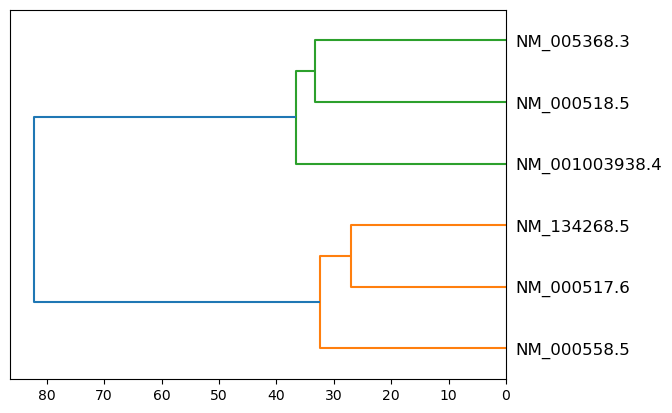

single


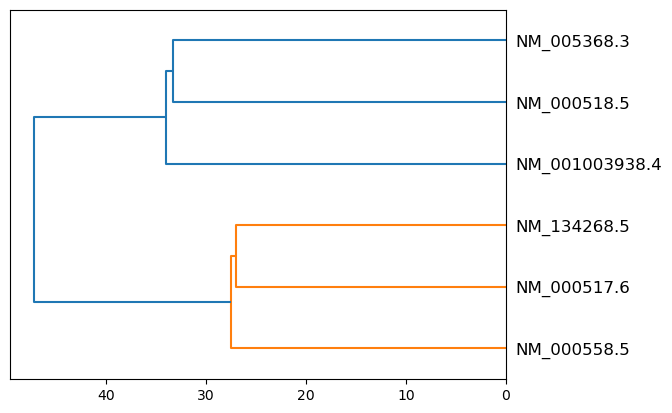

complete


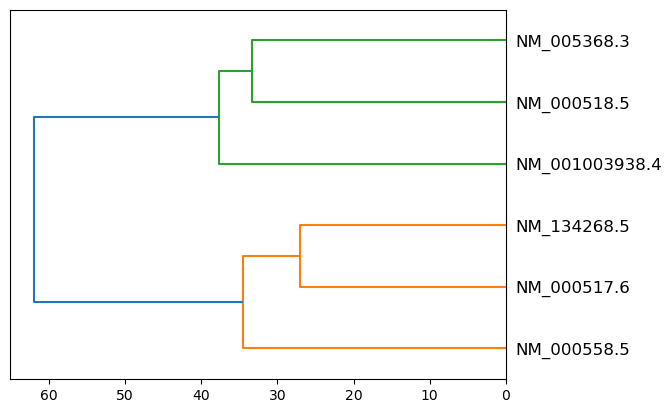

centroid


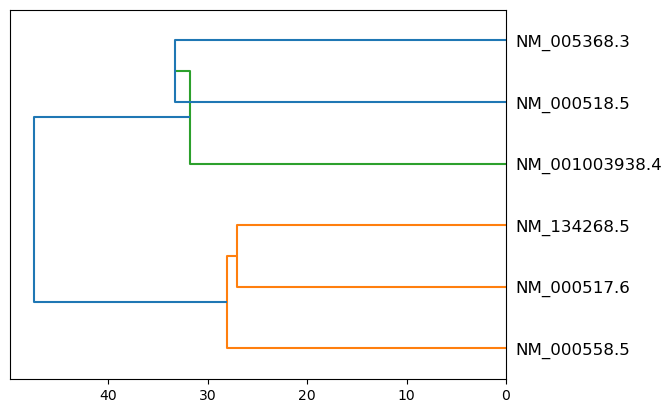

median


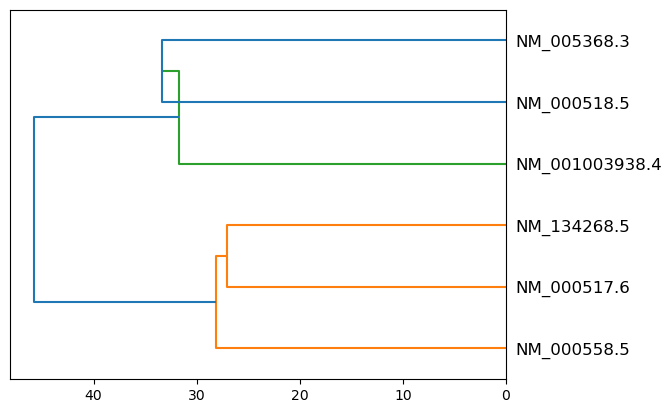

weighted


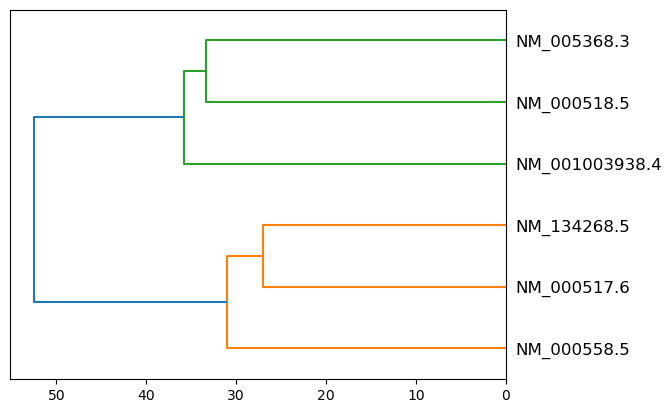

average


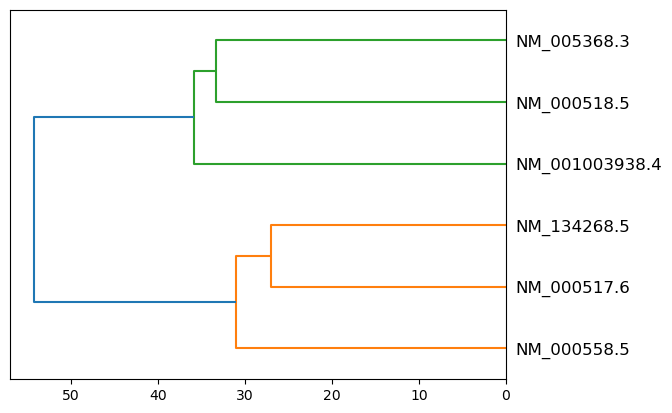

In [2]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import autoembedding.utils as utils
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
from autoembedding.embeddings_matrix import build_embeddings_matrix
#InteractiveShell.ast_node_interactivity = "all"

PATH = "dataset/globins/globins.json"
#PATH = "dataset/NEIS2157/NEIS2157.json"

embeddings_dict = utils.get_embeddings_dict(PATH)

IDs, embeddings_matrix = build_embeddings_matrix(
    embeddings_dict = embeddings_dict,
    embedder="dnabert",
    combiner_method="pca"
)

methods = ["ward", "single", "complete", "centroid", "median", "weighted", "average"]

condensed_distances = pdist(embeddings_matrix)

for method in methods:
    print(method)
    # Perform hierarchical clustering
    Z = linkage(condensed_distances, method=method)
    # Plot dendrogram
    dendrogram(Z, orientation="left", labels=IDs)

    plt.show()

# Get cluster labels
#max_d =30  # set the maximum distance between clusters
#labels = fcluster(Z, max_d, criterion='distance')
#print(labels)

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tanglegram as tg

# Building the embedding matix
IDs, embeddings_matrix_A = build_embeddings_matrix(
    embeddings_dict = embeddings_dict,
    embedder="prose",
    combiner_method="sum"
)

# Scaling
scaler = StandardScaler()
embeddings_matrix_A = scaler.fit_transform(embeddings_matrix_A)

# Principal component analysis
pca = PCA()
embeddings_matrix_A = pca.fit_transform(embeddings_matrix_A)

# Buliding an array encoding the pairwise distances between rows (observations) in the embedding matrix
condensed_distances_A = pdist(embeddings_matrix_A, metric="euclidean")

# Calculating the hierarchical clustering 
linkage_matrix_A = linkage(condensed_distances_A, method="average")

gt_matrix, gt_IDs = utils.newick_to_linkage("./dataset/globins/globins.dnd2")

# Plot tanglegram   
fig = tg.plot(
    linkage_matrix_A, 
    gt_matrix,
    labelsA=IDs,
    labelsB=gt_IDs,
    #sort="step2side", 
    link_kwargs = {},
    dend_kwargs={}
)

#plt.show()
print(gt_IDs, IDs)



INFO  : Finished optimising at entanglement 0.00 (tanglegram.tangle)


: 

: 

In [5]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

IDs = []
distances = []

# open the file
with open("./dataset/globins/globins.dist", "r") as f:
    # the first line is the size of the matrix
    size = int(f.readline())
    # each subsequent line is a row of the matrix preceded by the ID of the sequence
    for line in f:
        # split the line by spaces
        line = line.split()
        # the first element is the ID
        IDs.append(line[0])
        # the remaining elements are the distances
        distances.append(line[1:])

distances = np.array(distances, dtype=np.float32)


{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [45.0, 45.0, 55.0, 55.0],
  [13.75, 13.75, 50.0, 50.0]],
 'dcoord': [[0.0, 0.07395317640771963, 0.07395317640771963, 0.0],
  [0.0, 0.8740439874527464, 0.8740439874527464, 0.07395317640771963],
  [0.0, 0.9554746463105009, 0.9554746463105009, 0.8740439874527464],
  [0.0, 1.0164531124277991, 1.0164531124277991, 0.0],
  [0.9554746463105009,
   1.075330949926605,
   1.075330949926605,
   1.0164531124277991]],
 'ivl': ['NM_000518.5',
  'NM_001003938.4',
  'NM_000558.5',
  'NM_000517.6',
  'NM_134268.5',
  'NM_005368.3'],
 'leaves': [3, 4, 1, 2, 0, 5],
 'color_list': ['C1', 'C0', 'C0', 'C0', 'C0'],
 'leaves_color_list': ['C0', 'C0', 'C1', 'C1', 'C0', 'C0']}

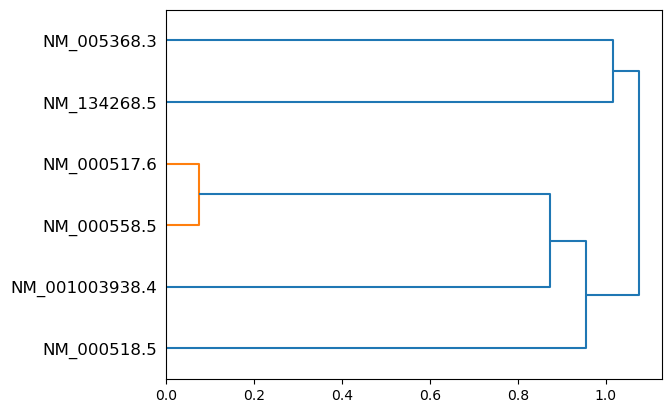

In [6]:
# Buliding an array encoding the pairwise distances between rows (observations) in the embedding matrix
condensed_distances = pdist(distances, metric="euclidean")

# Calculating the hierarchical clustering 
linkage_matrix = linkage(condensed_distances, method="average")

dendrogram(linkage_matrix, labels=IDs, orientation="right")

In [2]:
dendrogram(gt_matrix, labels=gt_IDs, orientation="right")
gt_IDs

NameError: name 'dendrogram' is not defined

In [3]:
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import adjusted_rand_score

n_clusters = 2

gt_labels = cut_tree(gt_matrix, n_clusters=n_clusters)
print(gt_labels)
gt_labels = [l[0] for l in gt_labels]

pred_labels = cut_tree(linkage_matrix_A, n_clusters=n_clusters)
print(pred_labels)
pred_labels = [l[0] for l in pred_labels ]

adjusted_rand_score(labels_true=gt_labels, labels_pred=pred_labels)


NameError: name 'gt_matrix' is not defined

Phylogenetic tree with clustalw2

In [8]:
from Bio.Align.Applications import ClustalwCommandline
from Bio import Phylo
import autoembedding.utils as utils
from ete3 import ClusterTree

cmd =  ClustalwCommandline("clustalw2", infile="dataset/emoglobina/emoglobina.fasta")
# stdout, stderr = cmd()
# tree = Phylo.read("dataset/emoglobina/emoglobina.dnd", format="newick")

print(cmd)

clustalw2 -infile=dataset/emoglobina/emoglobina.fasta


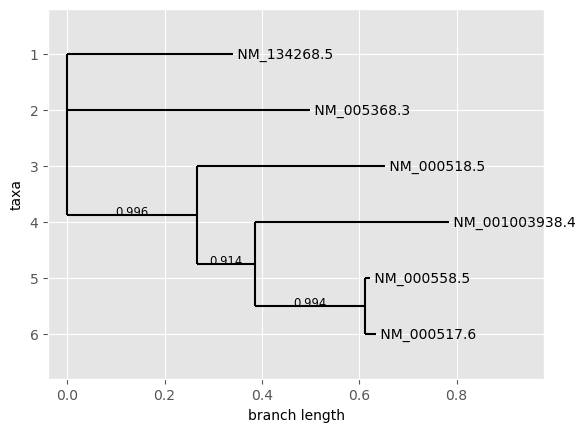

In [11]:
from Bio import Phylo
tree = Phylo.read("dataset/globins/globins.dnd2", format="newick")

tree
Phylo.draw(tree)